### Introduction
In this notebook, we will test out pulling the [llava-v1.6-7b](https://ollama.com/library/llava) and serving with [Ollama](https://ollama.com/) in SAP AI Core. Enhance [btp-generative-ai-hub-use-cases/01-social-media-citizen-reporting-genai-hub](https://github.com/SAP-samples/btp-generative-ai-hub-use-cases/tree/main/01-social-media-citizen-reporting-genai-hub) with Vision capability powered by the LLaVa models, in which the issues of public facilities reported by citizen can be automatically analyzed by the Vision API with its image. In addition, you can also run LLaMa 3, Phi3, Mistral, Mixtral, and other [supported models in Ollama](https://ollama.com/library). 

### Prerequisites
Before running this notebook, please assure you have performed the [Prerequisites](../../README.md) and [01-deployment.ipynb](01-deployment.ipynb). As a result, a deployment of Ollama scenario is running in SAP AI Core.<br/><br/>

If the configuration and deployment are created through SAP AI Launchpad, please manually update the configuration_id and deployment_id in [env.json](env.json)
```json
{
    "configuration_id": "<YOUR_CONFIGURATION_ID_OF_OLLAMA_SCENARIO>",
    "deployment_id": "<YOUR_DEPLOYMENT_ID_BASED_ON_CONFIG_ABOVE>"
}
```
 
### The high-level flow:
- Load configurations info
- Connect to SAP AI Core via SDK
- Check the status and logs of the deployment
- Pull model from ollama model repository through API
- Inference the model with OpenAI-compatible chat completion API


#### 1.Load config info 
- resource_group loaded from [config.json](../config.json)
- deployment_id(created in 01-deployment.ipynb) loaded [env.json](env.json)

In [51]:
import requests, json, base64
from ai_api_client_sdk.ai_api_v2_client import AIAPIV2Client

In [52]:
# Please replace the configurations below.
# config_id: The target configuration to create the deployment. Please create the configuration first.
with open("../config.json") as f:
    config = json.load(f)

with open("./env.json") as f:
    env = json.load(f)

deployment_id = env["deployment_id"]
resource_group = config.get("resource_group", "default")
print("deployment id: ", deployment_id, " resource group: ", resource_group)

deployment id:  dc8777fe661ff053  resource group:  oss-llm


#### 2.Initiate connection to SAP AI Core 

In [53]:
aic_sk = config["ai_core_service_key"]
base_url = aic_sk["serviceurls"]["AI_API_URL"] + "/v2/lm"
ai_api_client = AIAPIV2Client(
    base_url= base_url,
    auth_url=aic_sk["url"] + "/oauth/token",
    client_id=aic_sk['clientid'],
    client_secret=aic_sk['clientsecret'],
    resource_group=resource_group)

In [55]:
token = ai_api_client.rest_client.get_token()
headers = {
        "Authorization": token,
        'ai-resource-group': resource_group,
        "Content-Type": "application/json"}


#### 3.Check the deployment status 

In [56]:
# Check deployment status before inference request
deployment_url = f"{base_url}/deployments/{deployment_id}"
response = requests.get(url=deployment_url, headers=headers)
resp = response.json()    
status = resp['status']

deployment_log_url = f"{base_url}/deployments/{deployment_id}/logs?start=2024-03-25T01:35:58"


if status == "RUNNING":
        print(f"Deployment-{deployment_id} is running. Ready for inference request")
else:
        print(f"Deployment-{deployment_id} status: {status}. Not yet ready for inference request")
        #retrieve deployment logs
        #{{apiurl}}/v2/lm/deployments/{{deploymentid}}/logs.

response = requests.get(url=deployment_log_url, headers=headers)
print('Deployment Logs:\n', response.text)


Deployment-dc8777fe661ff053 is running. Ready for inference request
Deployment Logs:
 {
  "data": {
    "result": [
      {
        "container": "kserve-container",
        "msg": " * Starting nginx nginx",
        "pod": "dc8777fe661ff053-predictor-default-00001-deployment-557484jpmll",
        "timestamp": "2024-03-26T03:06:42.398182868+00:00"
      },
      {
        "container": "kserve-container",
        "msg": "   ...done.",
        "pod": "dc8777fe661ff053-predictor-default-00001-deployment-557484jpmll",
        "timestamp": "2024-03-26T03:06:42.403277873+00:00"
      },
      {
        "container": "kserve-container",
        "msg": "Couldn't find '/nonexistent/.ollama/id_ed25519'. Generating new private key.",
        "pod": "dc8777fe661ff053-predictor-default-00001-deployment-557484jpmll",
        "timestamp": "2024-03-26T03:06:42.412329435+00:00"
      },
      {
        "container": "kserve-container",
        "msg": "Your new public key is: ",
        "pod": "dc8777fe661f

#### 4.Pull the model from model repository into Ollama server
We'll pull the llava:lastest(namely llava:7b) from ollama's model repository into our ollama server in SAP AI Core. llava also comes with 13b and 34b models with higher accuracy, also required more resources. Please change the corresponding resource plan in byom-oss-llm-templates/ollama-template.yaml
- **llava:13b** Please change resource plan into **infer.m** or **infer.l** in [/byom-oss-llm-templates/ollama-template.yaml](../byom-oss-llm-templates/ollama-template.yaml)
- **llava:34b** Please change resource plan into **infer.l** in [/byom-oss-llm-templates/ollama-template.yaml](../byom-oss-llm-templates/ollama-template.yaml)

In [57]:
model = "llava" #llava-v1.6-7b
#model = "llava:13b" #Important: please change resource plan into infer.m in byom-oss-llm-templates/ollama-template.yaml
#model = "llava:34b" #Important: please change resource plan into infer.l in byom-oss-llm-templates/ollama-template.yaml

deployment = ai_api_client.deployment.get(deployment_id)
inference_base_url = f"{deployment.deployment_url}/v1"

##### 4.1 Pull the model

In [ ]:
# pull the model from ollama model repository
endpoint = f"{inference_base_url}/api/pull"
print(endpoint)

#let's pull the llava model
json_data = {  "name": model}

response = requests.post(url=endpoint, headers=headers, json=json_data)
print('Result:', response.text)

##### 4.2 Check if the target model(llava) listed in the model list.

In [59]:
# Check the model list 
endpoint = f"{inference_base_url}/api/tags"
print(endpoint)

response = requests.get(endpoint, headers=headers)
print('Result:', response.text)

https://api.ai.prod.eu-central-1.aws.ml.hana.ondemand.com/v2/inference/deployments/dc8777fe661ff053/v1/api/tags
Result: {"models":[{"name":"llava:latest","model":"llava:latest","modified_at":"2024-03-26T03:18:26.87178127Z","size":4733363377,"digest":"8dd30f6b0cb19f555f2c7a7ebda861449ea2cc76bf1f44e262931f45fc81d081","details":{"parent_model":"","format":"gguf","family":"llama","families":["llama","clip"],"parameter_size":"7B","quantization_level":"Q4_0"}}]}


#### 5.Inference Vision API
As of Mar 2024, Vision is only supported in [Ollama's Completion API](https://github.com/ollama/ollama/blob/main/docs/api.md#request-with-images), not yet available in the [OpenAI compatible Chat Completion API](https://github.com/ollama/ollama/blob/main/docs/openai.md#v1chatcompletions). <br/><br/>
In the following samples, we'll enhance [btp-generative-ai-hub-use-cases/01-social-media-citizen-reporting-genai-hub](https://github.com/SAP-samples/btp-generative-ai-hub-use-cases/tree/main/01-social-media-citizen-reporting-genai-hub) with Vision API powered by the LLaVa model.

In [60]:
completion_api_endpoint = f"{inference_base_url}/api/generate"
chat_api_endpoint = f"{inference_base_url}/api/chat"

##### 5.1 Preload the model into memory for fast inference
keep the model in the memory for 30 mins.

In [61]:
json_data = {
  "model": model,
  "keep_alive": "30m"
}

response = requests.post(url=completion_api_endpoint, headers=headers, json=json_data)
print('Result:', response.text)

Result: {"model":"llava","created_at":"2024-03-26T03:19:06.923595746Z","response":"","done":true}


##### 5.2 Helper functions to display the image and encode the image in base64

In [62]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_path):
    # Load the image
    img = mpimg.imread(image_path)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

Display the sample image

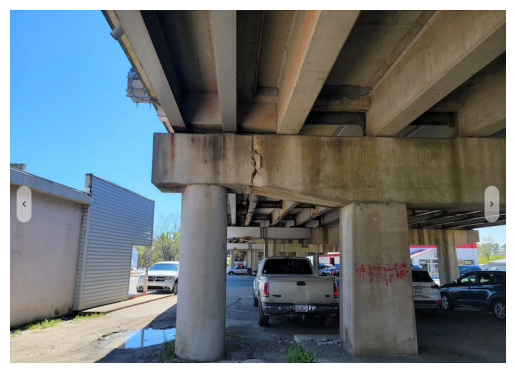

In [63]:
image_path = '../../resources/10-bridge-crack.png'
display_image(image_path)

Encode the image with base64

In [64]:
def image_to_base64_data_uri(image_path):
    with open(image_path, "rb") as img_file:
        base64_data = base64.b64encode(img_file.read()).decode('utf-8')
        #return f"data:image/png;base64,{base64_data}"
        return base64_data

data_uri = image_to_base64_data_uri(image_path)

##### 5.3 Vision Sample#1: Describe the image (a cracked bridge)
Let's start with a simple question to ask the model to describe the image in nature language.

In [65]:
sys_msg = "Describe the image"

json_data = {
  "model": model,
  "prompt": sys_msg,
  "format": "json", #json mode
  "images": [f"{data_uri}"],
  "stream": False #not streaming
}

response = requests.post(url=completion_api_endpoint, headers=headers, json=json_data)
print('Result:', response.text)

Result: {"model":"llava","created_at":"2024-03-26T03:19:35.757747723Z","response":"{ \"image_type\": \"photo\", \"image_description\": \"An image of a bridge with signs of disrepair. The bridge is overpassed by an underpass and has visible damage, with rust and paint peeling from the underside. The supports show signs of corrosion. The bridge structure is concrete, and there are no people or vehicles in the frame. It appears to be a sunny day, as the sky is clear.\" } ","done":true,"context":[733,16289,28793,27984,272,3469,733,28748,16289,4490,345,4075,28730,1123,1264,345,25903,548,345,4075,28730,6518,1264,345,2820,3469,302,264,9850,395,10090,302,704,9157,992,28723,415,9850,349,754,4119,286,486,396,916,4119,304,659,9141,6544,28725,395,14912,304,6192,757,9365,477,272,23759,547,28723,415,11562,1347,10090,302,1275,2737,296,28723,415,9850,4693,349,12230,28725,304,736,460,708,905,442,11999,297,272,4108,28723,661,8045,298,347,264,4376,1780,1370,28725,390,272,7212,349,3081,611,443,28705],"tot

##### 5.4 Vision Sample#2: Public Facilities Issue Spotter for [Citizen Reporting use case](https://github.com/SAP-samples/btp-generative-ai-hub-use-cases/tree/main/01-social-media-citizen-reporting-genai-hub) (e.g. Bridge Damage)
In next sample, we'll ask the llava model to be an Assistant of Public Facilities Issue Spotter for city council.
Responsible for analyzing images reported by citizens through a mobile app to identify issues related to public facilities. <br/>
Here are the tasks: <br/>
- 1.Analyze images reported by citizens through a mobile app to identify issues related to public facilities. If no issue identified, go to step 5, otherwise continue with next steps 
- 2.Extract photographic date and location information from images for accurate documentation.
- 3.Categorize identified issues based on predefined categories (e.g., infrastructure damage, cleanliness, safety hazards).
- 4.Assess the severity and priority of identified issues to determine appropriate action plans.
- 5.Output with JSON schema in triple quote as below: 
```json
{ "issue_identified": "{{true or false}}",
#below section only output when there is an issue identified
"title": "{{A title about the issue less than 100 characters}}",
"description": "{{A short description about the issue less than 300 characters}}",
"photo_date": "{{Extracted photographic date from its metadata in yyyy-mm-dd:hh:mm:ss format}}",
"longitude": "{{Extracted the longitude of photographic location from its metadata. Output -1 if fails to extract location info from image}}",
"latitude": "{{Extracted the latitude of photographic location from its metadata. Output -1 if fails to extract location info from image}}",
"category": "{{Identified category: 01-Infrastructure Damage, 02-Cleanliness, 03-Safety Hazards, 04-Duplicated}}",
"priority": "{{Identified priority: 01-Very High, 02-High, 03-Medium, 04-Low}}",
"suggested_action": "{{01-Immediate Attendance, 02-Schedule Inspection, 03-Schedule Service, 04-Refer to similar issue}}"
}
```

In [66]:
user_msg = r'''
You are a helpful Assistant of Public Facilities Issue Spotter for city council.
Responsible for analyzing images reported by citizens through a mobile app to identify issues related to public facilities. 
Here are your tasks:
1.Analyze images reported by citizens through a mobile app to identify issues related to public facilities. 
If no issue identified, go to step 5, otherwise continue with next steps 
2.Extract photographic date and location information from images for accurate documentation. 
3.Categorize identified issues based on predefined categories (e.g., infrastructure damage, cleanliness, safety hazards).
4.Assess the severity and priority of identified issues to determine appropriate action plans. 
5.Output with JSON schema in triple quote as below:
\"\"\" 
{ \"issue_identified\": \"{{true or false}}\", 
#below section only output when there is an issue identified\
\"title\": \"{{A short title about the issue}}\", 
\"description\": \"{{A detail description about the issue}}\", 
\"photo_date\": \"{{Extracted photographic date from its metadata in yyyy-mm-dd:hh:mm:ss format. Leave it blank if no metadata found in it.}}\", 
\"longitude\": \"{{Extracted longitude of photographic location from its metadata. Do not make up any number. Output -1 if fails to extract location info from image}}\",
\"latitude\": \"{{Extracted latitude of photographic location from its metadata. Do not make up any number. Output -1 if fails to extract location info from image}}\",
\"category\": \"{{Identified category: 01-Infrastructure Damage, 02-Cleanliness, 03-Safety Hazards, 04-Duplicated}}\",
\"priority\": \"{{Suggested Priority: 01-Very High, 02-High, 03-Medium, 04-Low}}\",
\"suggested_action\": \"{{01-Immediate Attendance, 02-Schedule Inspection, 03-Schedule Service, 04-Refer to similar issue }}\"
} 
\"\"\"
'''

json_data = {
  "model": model,
  "prompt": user_msg,
  "format": "json",
  "images": [data_uri],
  "stream": False,
}

response = requests.post(url=completion_api_endpoint, headers=headers, json=json_data)
print('Result:', response.text)

Result: {"model":"llava","created_at":"2024-03-26T03:20:06.369063844Z","response":"{\"issue_identified\": true,\n \"title\": \"Damaged Bridge Overpass\", \"description\": \"The bridge overpass in the image appears to be damaged with rust and discoloration on the structure. This could potentially lead to safety hazards.\", \"photo_date\": \"2023-04-18:06:57:19\", \"longitude\": -1, \"latitude\": -1, \"category\": \"01-Infrastructure Damage\", \"priority\": \"01-Very High\", \"suggested_action\": \"01-Immediate Attendance\"} ","done":true,"context":[733,16289,28793,995,460,264,10865,21631,302,4271,13924,3780,27766,24666,360,354,2990,14725,28723,1146,13532,1070,354,10148,14508,6203,5745,486,9893,1059,264,7578,954,298,9051,4382,5202,298,798,11675,28723,4003,460,574,9796,28747,28740,28723,27554,1374,6203,5745,486,9893,1059,264,7578,954,298,9051,4382,5202,298,798,11675,28723,1047,708,4291,10248,28725,576,298,3707,28705,28782,28725,5860,3688,395,1679,5944,28705,28750,28723,24958,9180,294,3608

##### 5.5 Vision Sample#3: Describe the image (e.g. a littered street)
Let's continue with another sample image about a littered street, asking the model to describe the image in nature language.

Display the sample image

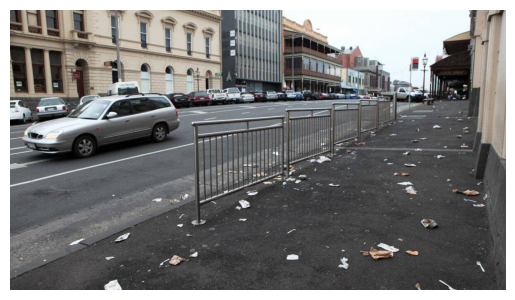

In [67]:
image_path = '../../resources/11-dirty-street.jpg'
display_image(image_path)

Encode the image with base64

In [68]:
data_uri = image_to_base64_data_uri(image_path)

Let's use Ollama's Chat API this time.

In [71]:
user_msg = "Spots on the public facility issue in the image, and Describe the issue in detail if any"

json_data = {
  "model": model,
  "messages": [
    {
      "role": "user",
      "content": user_msg,
      "images": [data_uri]    
    }
  ],
  "stream": False #not streaming
}

response = requests.post(url=chat_api_endpoint, headers=headers, json=json_data)
print('Result:', response.text)

Result: {"model":"llava","created_at":"2024-03-26T03:25:47.616239812Z","message":{"role":"assistant","content":" The image shows a street scene with litter scattered on the ground, particularly around the sidewalk and in the road. This indicates that there is a problem with waste management or public cleanup efforts in this area. The presence of trash, especially discarded items such as cigarette butts and paper debris, can create an unsightly environment and pose health risks if not properly disposed of. The litter also suggests inadequate maintenance by local authorities or the need for increased education on proper waste disposal among residents and visitors to this area. Additionally, it might indicate that the community is facing issues related to pollution and public cleanliness. "},"done":true,"total_duration":4091285555,"load_duration":2019822,"prompt_eval_count":1,"prompt_eval_duration":1277779000,"eval_count":128,"eval_duration":2788947000}


##### 5.6 Vision Sample#4: Public Facilities Issue Spotter for [Citizen Reporting use case](https://github.com/SAP-samples/btp-generative-ai-hub-use-cases/tree/main/01-social-media-citizen-reporting-genai-hub) (e.g. a littered street)
In next sample, we'll ask the llava model to be an Assistant of Public Facilities Issue Spotter for city council.
Responsible for analyzing images reported by citizens through a mobile app to identify issues related to public facilities. <br/>
Here are the tasks: <br/>
- 1.Analyze images reported by citizens through a mobile app to identify issues related to public facilities. If no issue identified, go to step 5, otherwise continue with next steps 
- 2.Extract photographic date and location information from images for accurate documentation.
- 3.Categorize identified issues based on predefined categories (e.g., infrastructure damage, cleanliness, safety hazards).
- 4.Assess the severity and priority of identified issues to determine appropriate action plans.
- 5.Output with JSON schema in triple quote as below: 
```json
{ "issue_identified": "{{true or false}}",
#below section only output when there is an issue identified
"title": "{{A title about the issue less than 100 characters}}",
"description": "{{A short description about the issue less than 300 characters}}",
"photo_date": "{{Extracted photographic date from its metadata in yyyy-mm-dd:hh:mm:ss format}}",
"longitude": "{{Extracted the longitude of photographic location from its metadata. Output -1 if fails to extract location info from image}}",
"latitude": "{{Extracted the latitude of photographic location from its metadata. Output -1 if fails to extract location info from image}}",
"category": "{{Identified category: 01-Infrastructure Damage, 02-Cleanliness, 03-Safety Hazards, 04-Duplicated}}",
"priority": "{{Identified priority: 01-Very High, 02-High, 03-Medium, 04-Low}}",
"suggested_action": "{{01-Immediate Attendance, 02-Schedule Inspection, 03-Schedule Service, 04-Refer to similar issue}}"
}
```
<br/>
Let's use Ollama's Chat API this time.

In [72]:
user_msg = r'''
You are a helpful Assistant of Public Facilities Issue Spotter for city council.
Responsible for analyzing images reported by citizens through a mobile app to identify issues related to public facilities. 
Here are your tasks:
1.Analyze images reported by citizens through a mobile app to identify issues related to public facilities. 
If no issue identified, go to step 5, otherwise continue with next steps 
2.Extract photographic date and location information from images for accurate documentation. 
3.Categorize identified issues based on predefined categories (e.g., infrastructure damage, cleanliness, safety hazards).
4.Assess the severity and priority of identified issues to determine appropriate action plans. 
5.Output with JSON schema in triple quote as below:
\"\"\" 
{ \"issue_identified\": \"{{true or false}}\", 
#below section only output when there is an issue identified\
\"title\": \"{{A short title about the issue}}\", 
\"description\": \"{{A detail description about the issue}}\", 
\"photo_date\": \"{{Extracted photographic date from its metadata in yyyy-mm-dd:hh:mm:ss format. Leave it blank if no metadata found in it.}}\", 
\"longitude\": \"{{Extracted longitude of photographic location from its metadata. Do not make up any number. Output -1 if fails to extract location info from image}}\",
\"latitude\": \"{{Extracted latitude of photographic location from its metadata. Do not make up any number. Output -1 if fails to extract location info from image}}\",
\"category\": \"{{Identified category: 01-Infrastructure Damage, 02-Cleanliness, 03-Safety Hazards, 04-Duplicated}}\",
\"priority\": \"{{Suggested Priority: 01-Very High, 02-High, 03-Medium, 04-Low}}\",
\"suggested_action\": \"{{01-Immediate Attendance, 02-Schedule Inspection, 03-Schedule Service, 04-Refer to similar issue }}\"
} 
\"\"\"
'''

json_data = {
  "model": model,
  "messages": [
    {
      "role": "user",
      "content": user_msg,
      "images": [data_uri]    
    }
  ],
  "format": "json", #JSON mode
  "stream": False #not streaming
}

response = requests.post(url=chat_api_endpoint, headers=headers, json=json_data)
print('Result:', response.text)

Result: {"model":"llava","created_at":"2024-03-26T03:27:32.937728263Z","message":{"role":"assistant","content":"{\"issue_identified\": true,\n \"title\": \"Trash-filled sidewalk by the road\", \"description\": \"The sidewalk on the side of the street is littered with discarded trash and items, posing a cleanliness issue and potential safety hazard.\", \"photo_date\": \"2023-05-14:18:05\", \"longitude\": -167, \"latitude\": -39.723, \"category\": \"02-Cleanliness\", \"priority\": \"03-Medium\", \"suggested_action\": \"03-Schedule Service\"} "},"done":true,"total_duration":5165857364,"load_duration":1866237,"prompt_eval_count":1,"prompt_eval_duration":2045334000,"eval_count":138,"eval_duration":3094746000}
